# Lab 9 - Web Scraping
---
### <font color='red'> install_tutorial start
In today's lab, we are going to download data from the internet using an API. API stands for application programming interface. Companies often create APIs as a way to allow users to more directly interact with their servers to retrieve data. Today, we are going to be using Twitter's API to download tweets to get some experience with larger datasets.

In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import warnings

# These are the utility functions in the twitter_utils.py file
from twitter_utils import *

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
import re
import json

## Setup
---
For this lab, we will be importing utility functions to interact with Twitter's API. Underneath the hood, these utility functions use the `tweepy` package, which is the how you can interface with Twitter's API using `python`. First, we need to install `tweepy` so that our utility functions will be able to use use it. If you have time at the end of this lab, you can look in the `twitter_utils.py` file in this folder and try to understand how the utility functions work.

In [2]:
!pip install tweepy

You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up for a Twitter developer account. Note that **anyone who has your authentication keys can post as you**. In order to protect your keys, you will be storing them in a separate file, which we have called `keys.json`, and reading them into this notebook from that file. Also note that **Twitter limits developers to a certain rate of data requests**. This means that if you make too many API calls in a short period of time, Twitter may block you from retrieving data for a certain period of time. Avoid rerunning cells that retrieve new tweets.

Follow the instructions below to get your Twitter API keys.  **Read the instructions completely before starting.**

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one; if you prefer to not do this assignment under your regular account, feel free to create a throw-away account.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup) by clicking the 'Apply' button on the top right of the page. Attach it to your Twitter account. You'll have to fill out a form describing what you want to do with the developer account. Explain that you are doing this for a class at UC Berkeley and that you don't know exactly what you're building yet and just need the account to get started. These applications are approved by some sort of AI system, so it doesn't matter exactly what you write.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.  You don't need to provide a callback URL.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file `keys.json` in the same folder as this file and replace the placeholders with your keys.

Now you should be all ready to go! Let's test that you have correctly set up your developer account and the `keys.json` folder. The following cell loads your keys into this notebook, then validates them with the Twitter API. It should display your Twitter username without any warnings.

In [3]:
import json
key_file = "keys.json" # Add your keys to keys.json before running this cell

# Loading your keys from keys.json
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

# Validate keys.
# If your notebook does not print out "The keys are valid. Your username is: <your username>"
# you may have copied and pasted your keys incorrectly.
validate_authentication(keys)

The keys are valid. Your username is: IreneFarah


If you are getting any errors in this cell, ask a TA for help. If you do not have valid keys, you will not be able to use the API.

## Downloading Tweets
---
### <font color='red'> webscraping_tutorial start
Now we should be ready to download some tweets! In the following cell, we use one of the utility functions to download recent tweets with the hashtag "#gentrification". This cell can take a few minutes to finish running.

In [4]:
# Note that you do not write the actual hashtag symbol
gentrification = download_recent_tweets_by_hashtag(hashtag = "gentrification",
                                                   keys = keys,
                                                   count = 100)

If you are running into errors downloading these tweets, uncomment and run the following cell to load in tweets that we scraped earlier.

In [5]:
# gentrification = load_tweets('gentrification.json')

Similarly, if you download any datasets during this lab that you would like to save for later, you can use the `save_tweets()` function, which takes as its arguments a list of dictionaries and a name for the new file you are writing.

We now have `gentrification` assigned to a list with each element corresponding to a tweet. Let's examine one of these elements to get a better understanding of our data.

In [6]:
# This accesses the first (zero index) element of the list
gentrification[0]

{'created_at': 'Mon Apr 05 04:21:46 +0000 2021',
 'id': 1378925806538350594,
 'id_str': '1378925806538350594',
 'text': 'RT @DonnieReid16: @mims Tell me why Im not shocked? Its done everywhere.\nThey pick minority neighborhood, label it as historic, jack up the…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'DonnieReid16',
    'name': 'SgtPapaBear',
    'id': 951991910436139010,
    'id_str': '951991910436139010',
    'indices': [3, 16]},
   {'screen_name': 'mims',
    'name': 'Christopher Mims',
    'id': 1769191,
    'id_str': '1769191',
    'indices': [18, 23]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 870877

This is an example of another `python` data structure called a *dictionary*. Dictionaries store *values* by associating them with a *key* rather than by an integer index. You can access the values stored in a dictionary using bracket notation just like a list. For example:

In [7]:
# In this dictionary, the keys are strings, and the values are all numbers
d = {'a': 1,
    'b': 2,
    'c': 3}

d['a']

1

## Data Cleaning
### <font color='red'> Minute 4:20
---
The dictionary we were looking at above is a little bit hard to interpret because there dictionaries nested inside of some our keys. We can look only at the first level of keys in our dictionary by using the `.keys()` method.

In [8]:
gentrification[0].keys()
# You can also use .values() to access all of the values

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

Unfortunately, Twitter by default does not attach geographic data to the metadata of each tweet. To get around this, we can use the location associated to the account of each poster. First, we want to extract only the parts of the data that are relevant to what we are looking for. To do this, we first need to turn our list of dictionaries into a `pandas DataFrame`. Fortunately, there is a function that can do this easily for us.

In [9]:
gentrification_df = pd.DataFrame(gentrification)
gentrification_df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,Mon Apr 05 04:21:46 +0000 2021,1378925806538350594,1378925806538350594,"RT @DonnieReid16: @mims Tell me why Im not shocked? Its done everywhere.\nThey pick minority neighborhood, label it as historic, jack up the…",False,"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'DonnieReid16', 'name': 'SgtPapaBear', 'id': 951991910436139010, 'id_str': '951991910436139010', 'indices': [3, 16]}, {'screen_name': 'mims', 'name': 'Christopher Mims', 'id': 1769191, 'id_str': '1769191', 'ind...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,5,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Mon Apr 05 03:29:03 +0000 2021,1378912541473181696,1378912541473181696,” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +… https://t.co/ydkyumuNtd,True,"{'hashtags': [{'text': 'WorkingClass', 'indices': [2, 15]}, {'text': 'CanaryInTheCoalMine', 'indices': [26, 46]}, {'text': 'culture', 'indices': [50, 58]}, {'text': 'nourish', 'indices': [105, 113]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ydkyumuN...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://publicize.wp.com/"" rel=""nofollow"">WordPress.com</a>",NaN,None,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
2,Mon Apr 05 02:48:25 +0000 2021,1378902315344666624,1378902315344666624,RT @CaliLiliIndies: ” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +stre…,False,"{'hashtags': [{'text': 'WorkingClass', 'indices': [22, 35]}, {'text': 'CanaryInTheCoalMine', 'indices': [46, 66]}, {'text': 'culture', 'indices': [70, 78]}, {'text': 'nourish', 'indices': [125, 133]}], 'symbols': [], 'user_mentions': [{'screen_name': 'CaliLiliIndies', 'name':...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,None,...,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Mon Apr 05 02:20:20 +0000 2021,1378895247833493504,1378895247833493504,"@CReinhardtz @DenverWestword 💥#ForTheRecord, pop. growth in #Denver--by way of @MayorHancock &amp; @DenCityCouncil allo… https://t.co/TEP5cU16ec",True,"{'hashtags': [{'text': 'ForTheRecord', 'indices': [30, 43]}, {'text': 'Denver', 'indices': [60, 67]}], 'symbols': [], 'user_mentions': [{'screen_name': 'CReinhardtz', 'name': 'Charles Reinhardt McGarvey', 'id': 238646241, 'id_str': '238646241', 'indices': [0, 12]}, {'screen_n...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",1.378852e+18,1378851887672221696,...,0,1,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Mon Apr 05 01:28:51 +0000 2021,1378882294182768640,1378882294182768640,"#ConcreteCowboy was a bit more upbeat than #TheLastBlackManinSanFrancisco, both offer commentary on home and displa… https://t.co/IQccb2O11f",True,"{'hashtags': [{'text': 'ConcreteCowboy', 'indices': [0, 15]}, {'text': 'TheLastBlackManinSanFrancisco', 'indices': [43, 73]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/IQccb2O11f', 'expanded_url': 'https://twitter.com/i/web/status/1378882294182768640...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",1.378776e+18,1378776386513596418,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN


### <font color='red'> Minute 7:17  
Next, we want to extract out only the columns that are relevant to us. Discarding columns that do not help us answer our question can be helpful because it prevents the computer from having to do unnecessary computations. However, if we want to be able to connect any conclusions we make after we get rid of columns, it is helpful to keep an identifying column in your `DataFrame` even if you are not performing analyses on it.

In [10]:
users = gentrification_df[['id', 'user']]

Let's take a closer look at an element of the `user` column.

In [11]:
users.loc[0, 'user']

{'id': 870877024260419584,
 'id_str': '870877024260419584',
 'name': 'Jaclyn Jemison',
 'screen_name': 'JemisonJaclyn',
 'location': 'Philadelphia, PA',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 4227,
 'friends_count': 5002,
 'listed_count': 12,
 'created_at': 'Sat Jun 03 05:37:17 +0000 2017',
 'favourites_count': 86096,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 92682,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': None,
 'profile_background_image_url_https': None,
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/1348687057007345665/AkvQo-bU_normal.jpg',
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1348687057007345665/AkvQo-bU_normal.jpg',
 'profile_banner_

### <font color='red'> Minute 10:50
In each row, the `user` column contains another dictionary with information about the user who posted the tweet. We can access the user's location using the `location` key.

The strategy that we are going to use to extract the locations from each user will be to iterate through the rows of `users`; at each row we will add the tweet id and the user location to a new dictionary. This dictionary will then be added to a list. Once we have iterated through all of the rows of `users`, we will convert our final list of dictionaries into a `DataFrame`.

In [12]:
# Create an empty list.
locations_list = list()

for i in range(len(users)):
    # Create an empty dictionary.
    new_entry = {}
    # Copy the tweet id into the new dictionary.
    new_entry['id'] = users.loc[i, 'id']
    # Create a new key ('location') and assign it to the location of the user who
    # wrote that tweet.
    new_entry['location'] = users.loc[i, 'user']['location']
    # Append the dictionary as another element of our list.
    locations_list.append(new_entry)
    
# Transform our list into a DataFrame. As before, each element of the list becomes
# a row in the DataFrame, and each key becomes a column.
all_locations = pd.DataFrame(locations_list)

# Display the first 10 tweets.
all_locations.head(10)

,id,location
0,1378925806538350594,"Philadelphia, PA"
1,1378912541473181696,calililiindies.com
2,1378902315344666624,calililiindies.com
3,1378895247833493504,"Denver, CO"
4,1378882294182768640,"Kansas, USA"
5,1378876481934405636,"Florida, USA"
6,1378873246058221570,
7,1378869383234256896,United States
8,1378865393633230852,
9,1378863408985030665,"Ministry of Magic, London"


### <font color='red'> Minute 17:59
Clearly this isn't a foolproof method, since the location associated with an account may have little bearing on the actual location from which a tweet was posted. Also, not all users have a specific location connected to their account. Depending on the data you have pulled from Twitter, you may also notice that some of the "locations" are not actually real places. We can do a bit of data cleaning to filter out the rows that contain true locations. First, let's get rid of the rows that do not contain any text at all in the `location` column.

In [13]:
# Create an empty DataFrame with the columns 'location' and 'id'
no_empties = pd.DataFrame(columns = ['id', 'location'])
for i in range(len(all_locations)):
    # This filters out tweets whose location column is an empty string.
    if all_locations.loc[i, "location"] != '':
        no_empties = no_empties.append(all_locations.loc[i,:])
no_empties.head(10)

,id,location
0,1378925806538350594,"Philadelphia, PA"
1,1378912541473181696,calililiindies.com
2,1378902315344666624,calililiindies.com
3,1378895247833493504,"Denver, CO"
4,1378882294182768640,"Kansas, USA"
5,1378876481934405636,"Florida, USA"
7,1378869383234256896,United States
9,1378863408985030665,"Ministry of Magic, London"
10,1378858823633473539,BumFucked Egypt
11,1378805448422391814,"near, not in, Lake Ontario"


This looks pretty good! We would still like to filter through our locations for places that actually exist. Let's use the `.groupby()` method to take a look at what locations we have in our data.

The `.groupby()` method takes in a table, a column, and optionally, an aggregate function (the default is count() which counts how many rows have the same value for the column we are grouping by. Other options include sum() and max() or min()). Groupby goes through each row, looks at the column that has been given to it of the current row, and groups each row based on if they have the same value at given column. After it has a list of rows for each distinct column value, it applies the aggregate function for each list, and returns a table of each distinct column value with the aggregate function applied to the rows that corresponded with the column.

In [14]:
no_empties.groupby('location').count()

,id
location,
A Galaxy Near You!,1
Arab world,1
"Atlanta, GA",2
"BALTIMORE,MD",1
Barcelona,2
...,...
"near, not in, Lake Ontario",1
north charlotte nc,1
she!her | 17 | ebony,1


If you scroll through this list, you will likely see a whole litany of "locations" that do not resemble locations since the user is allowed to write whatever they like as their location. We do not have time to day to sort through all of these right now, so we are goign to move on to a few other techniques that we can use to analyze these kinds of data.

## Scraping Tweets by Location
### <font color='red'> Minute 25:25
---
Since many of the tweets we scraped earlier do not have useful locations, we may want to filter by location when we ask the API for tweets. We can use the same function as before, using the optional `location` argument. The format of the location argument is `"latitude,longitude,radius"`. The following code searches for tweets hashtagged "gentrification" within a 5 km radius of the Temescal Oakland area.

In [15]:
gentrification_oak = download_recent_tweets_by_hashtag(hashtag = "gentrification",
                                                       keys = keys,
                                                       location = "37.829314,-122.264433,5km",
                                                       count = 100)

If you are running into errors downloading these tweets, uncomment and run the following cell to load in tweets that we scraped earlier.

In [16]:
# gentrification_oak = load_tweets('gentrification_oak.json')

**Your turn:** Let's use the procedure we went through earlier to find the most common user location in the `gentrification_oak` tweets. We've provided some starter code, but you need to fill in wherever you see a `...`!

In [17]:
users_oak = pd.DataFrame(gentrification_oak)
users_oak = users_oak [['id', 'user']] # select columns of interest
users_oak.head()

,id,user
0,1378925806538350594,"{'id': 870877024260419584, 'id_str': '870877024260419584', 'name': 'Jaclyn Jemison', 'screen_name': 'JemisonJaclyn', 'location': 'Philadelphia, PA', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 4227, 'friend..."
1,1378912541473181696,"{'id': 594100783, 'id_str': '594100783', 'name': 'CaliLili™🧜🏾🧜🏼‍♀️🧜🏽‍♀️🏄🏼‍♀️🏄🏾‍♀️🦀🎬🎼🏝️', 'screen_name': 'CaliLiliIndies', 'location': 'calililiindies.com ', 'description': '©clili™CaliLiliIndies™🏝️PicturesWordsMusicInMotion™🎬🎶 feMt0™studi0🌸CuttingEdgeOfThePacific™🦀Declaration..."
2,1378902315344666624,"{'id': 594100783, 'id_str': '594100783', 'name': 'CaliLili™🧜🏾🧜🏼‍♀️🧜🏽‍♀️🏄🏼‍♀️🏄🏾‍♀️🦀🎬🎼🏝️', 'screen_name': 'CaliLiliIndies', 'location': 'calililiindies.com ', 'description': '©clili™CaliLiliIndies™🏝️PicturesWordsMusicInMotion™🎬🎶 feMt0™studi0🌸CuttingEdgeOfThePacific™🦀Declaration..."
3,1378895247833493504,"{'id': 1269650482911301632, 'id_str': '1269650482911301632', 'name': 'Susan-Karen', 'screen_name': 'realsusankaren', 'location': 'Denver, CO', 'description': 'Tax the Rich • Abolish the Police • Demand Justice • Speak up • Show up • #BLM ☞#MessageToTheMayor ⇨ #StopTheSweeps 🚫..."
4,1378882294182768640,"{'id': 29109727, 'id_str': '29109727', 'name': 'Randal Maurice Jelks', 'screen_name': 'drjelks', 'location': 'Kansas, USA', 'description': 'Author, EP @i_americafilm, A knee-grow from #NOLA byway of #Chicago, #GrandRapids and #LawrenceKS and all other parts of the globe', 'ur..."


In [18]:
locations_list_oak = list()
for i in range(len(users_oak)):
    new_entry = {}
    new_entry['id'] = users_oak.loc[i, 'id']
    new_entry['location'] = users_oak.loc[i, 'user']['location']
    locations_list_oak.append(new_entry) # we want to add the new entry to our list
all_locations_oak = pd.DataFrame(locations_list_oak) # turn the list into a DataFrame

no_empties_oak = pd.DataFrame(columns = ['id', 'location'])
for i in range(len(all_locations_oak)):
    if all_locations_oak.loc[i, "location"] != '':
        no_empties_oak = no_empties_oak.append(all_locations_oak.loc[i,:])
        
grouped_locations = no_empties_oak.groupby('location').count()

grouped_locations.head()

,id
location,
A Galaxy Near You!,1
Arab world,1
"Atlanta, GA",2
"BALTIMORE,MD",1
Barcelona,2


## Temporal Data
### <font color='red'> Minute 29:45
---
Another facet of the tweets that you may want to analyze is the time at which they were posted. Currently, the only way we have information about the time the tweets were posted is in the `'created_at'` column, which is a string. As you may remember from the Introductory lab, `python` compares strings by assigning values to the letters themselves based on their position in the alphabet. We want to convert these strings to `datetime` objects, which will tell `python` at what time tweets were posted.

In [19]:
post_time = pd.DataFrame(gentrification_oak)[['id', 'created_at']]
post_time['time'] = pd.to_datetime(post_time['created_at'])
post_time['time'].head()

0   2021-04-05 04:21:46+00:00
1   2021-04-05 03:29:03+00:00
2   2021-04-05 02:48:25+00:00
3   2021-04-05 02:20:20+00:00
4   2021-04-05 01:28:51+00:00
Name: time, dtype: datetime64[ns, UTC]

Now that each string has been converted into a `datetime` object, we can extract the day, hour, minute, etc. of each time point like so

In [20]:
post_time.loc[0, 'time'].day

5

In [21]:
post_time.loc[0, 'time'].hour

4

In [22]:
post_time.loc[0, 'time'].minute

21

Notice that we are not adding parentheses at the end of each line. That is because the `.day`, `.hour`, and `.minute` are not *functions* we are calling, but rather *attributes* of the particular `datetime` object. If we want to look at the time of day that people tend to tweet about #gentrification, we can extract these attributes.

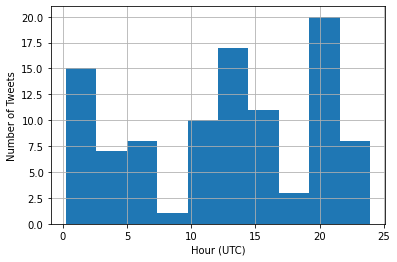

In [23]:
post_time['hour'] = [post_time.loc[i, 'time'].hour + post_time.loc[i, 'time'].minute/60 +
                     post_time.loc[i, 'time'].second/3600 for i in range(len(post_time))]
post_time['hour'].hist()
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of Tweets");

**Question:** What observations or trends do you notice about this graph?

**Question:** What could be improved about this graph or the process we used to obtain the data that generated it?

## Sentiment Analysis
### <font color='red'> Minute 32:27
---
We can use the words the tweets to measure the sentiment, or the positive/negative feeling generated by the tweet. To do so we will be using the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment), which is a rule-based sentiment analysis tool specifically designed for social media. It even includes emojis! Run the following cell to load in the lexicon.

In [24]:
vader = load_vader()
vader.iloc[500:510, :]

,polarity
sent,
ache,-1.6
ached,-1.6
aches,-1.0
achievable,1.3
aching,-2.2
acquit,0.8
acquits,0.1
acquitted,1.0
acquitting,1.3


The more positive the polarity of a word, the more positive feeling the word evokes in the reader. All of the words in `vader` are all lowercase, while many of our tweets are not. We need to modify the text in the tweets so that the words in our tweets will match up with the words stored in `vader`. Additionally, we need to remove punctuation since that will cause the words to not match up as well. We will put these modified tweets into another column in our `DataFrame` so that we can still have access to them later.

In [25]:
# Select our columns of interest
tweets_and_retweets = pd.DataFrame(gentrification_oak)[['id', 'text', 'retweet_count']]

# Set the index of the DataFrame to the tweet ID. This step is necessary
# in order to use our utility functions.
tweets_and_retweets.set_index('id', inplace = True)

# Remove punctuation and lowercase tweets
tweets_and_retweets['cleaned'] = clean_tweets(tweets_and_retweets['text'])

tweets_and_retweets.head()

,text,retweet_count,cleaned
id,,,
1378925806538350594,"RT @DonnieReid16: @mims Tell me why Im not shocked? Its done everywhere.\nThey pick minority neighborhood, label it as historic, jack up the…",5,rt donniereid16 mims tell me why im not shocked its done everywhere \nthey pick minority neighborhood label it as historic jack up the
1378912541473181696,” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +… https://t.co/ydkyumuNtd,0,workingclass artist is canaryinthecoalmine of culture she represents free spirit my work seeks to nourish https t co ydkyumuntd
1378902315344666624,RT @CaliLiliIndies: ” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +stre…,1,rt calililiindies workingclass artist is canaryinthecoalmine of culture she represents free spirit my work seeks to nourish stre
1378895247833493504,"@CReinhardtz @DenverWestword 💥#ForTheRecord, pop. growth in #Denver--by way of @MayorHancock &amp; @DenCityCouncil allo… https://t.co/TEP5cU16ec",0,creinhardtz denverwestword fortherecord pop growth in denver by way of mayorhancock amp dencitycouncil allo https t co tep5cu16ec
1378882294182768640,"#ConcreteCowboy was a bit more upbeat than #TheLastBlackManinSanFrancisco, both offer commentary on home and displa… https://t.co/IQccb2O11f",0,concretecowboy was a bit more upbeat than thelastblackmaninsanfrancisco both offer commentary on home and displa https t co iqccb2o11f


Next, we want to merge our sentiment lexicon with our cleaned tweets. 

In [26]:
tweets_and_retweets['polarity'] = compose_polarity(tweets_and_retweets, vader)
tweets_and_retweets.head()

,text,retweet_count,cleaned,polarity
id,,,,
1378925806538350594,"RT @DonnieReid16: @mims Tell me why Im not shocked? Its done everywhere.\nThey pick minority neighborhood, label it as historic, jack up the…",5,rt donniereid16 mims tell me why im not shocked its done everywhere \nthey pick minority neighborhood label it as historic jack up the,-1.3
1378912541473181696,” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +… https://t.co/ydkyumuNtd,0,workingclass artist is canaryinthecoalmine of culture she represents free spirit my work seeks to nourish https t co ydkyumuntd,3.0
1378902315344666624,RT @CaliLiliIndies: ” #WorkingClass artist is #CanaryInTheCoalMine of #culture. She represents free-spirit. My work seeks to #nourish +stre…,1,rt calililiindies workingclass artist is canaryinthecoalmine of culture she represents free spirit my work seeks to nourish stre,3.0
1378895247833493504,"@CReinhardtz @DenverWestword 💥#ForTheRecord, pop. growth in #Denver--by way of @MayorHancock &amp; @DenCityCouncil allo… https://t.co/TEP5cU16ec",0,creinhardtz denverwestword fortherecord pop growth in denver by way of mayorhancock amp dencitycouncil allo https t co tep5cu16ec,1.6
1378882294182768640,"#ConcreteCowboy was a bit more upbeat than #TheLastBlackManinSanFrancisco, both offer commentary on home and displa… https://t.co/IQccb2O11f",0,concretecowboy was a bit more upbeat than thelastblackmaninsanfrancisco both offer commentary on home and displa https t co iqccb2o11f,0.0


### <font color='red'> Minute 45:20 Questions and recap of sentiment analysis
### <font color='red'> Minute 50:57
Next, we want to see if more polarizing tweets are retweeted more often. To do this, we can plot the `polarity` and `retweet_count` columns against each other.

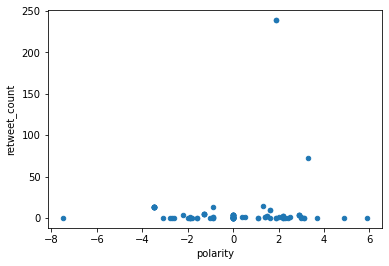

In [27]:
tweets_and_retweets.plot('polarity', 'retweet_count', kind='scatter');

**Question:** What conclusions can you draw about polarity and retweets from this graph? How does this compare with your assumptions?

## Your turn!
### <font color='red'> Minute 51:58
---
If time allows, try these exercises on your own or as a class!

**Exercise 1:** Using the `gentrification_oak` tweets, make a histogram of the time of day the tweets were posted. Note that if you would like the x-axis of the plot to reflect the correct time of day, you will have to convert the time from UTC to PDT.

In [28]:
# YOUR CODE HERE
post_time = pd.DataFrame(gentrification_oak)[['id', 'created_at']]
post_time['time'] = pd.to_datetime(post_time['created_at'])
post_time['time'].head()
post_time

,id,created_at,time
0,1378925806538350594,Mon Apr 05 04:21:46 +0000 2021,2021-04-05 04:21:46+00:00
1,1378912541473181696,Mon Apr 05 03:29:03 +0000 2021,2021-04-05 03:29:03+00:00
2,1378902315344666624,Mon Apr 05 02:48:25 +0000 2021,2021-04-05 02:48:25+00:00
3,1378895247833493504,Mon Apr 05 02:20:20 +0000 2021,2021-04-05 02:20:20+00:00
4,1378882294182768640,Mon Apr 05 01:28:51 +0000 2021,2021-04-05 01:28:51+00:00
...,...,...,...
95,1377947528289787904,Fri Apr 02 11:34:26 +0000 2021,2021-04-02 11:34:26+00:00
96,1377931692950892546,Fri Apr 02 10:31:30 +0000 2021,2021-04-02 10:31:30+00:00
97,1377930820204126214,Fri Apr 02 10:28:02 +0000 2021,2021-04-02 10:28:02+00:00
98,1377930322373971973,Fri Apr 02 10:26:04 +0000 2021,2021-04-02 10:26:04+00:00


In [29]:
from datetime import datetime
from pytz import timezone
import pytz

In [30]:
post_time_pst = post_time.set_index('time')
post_time_pst=post_time_pst.tz_convert('US/Central')
post_time_pst.reset_index(inplace=True)
post_time_pst

,time,id,created_at
0,2021-04-04 23:21:46-05:00,1378925806538350594,Mon Apr 05 04:21:46 +0000 2021
1,2021-04-04 22:29:03-05:00,1378912541473181696,Mon Apr 05 03:29:03 +0000 2021
2,2021-04-04 21:48:25-05:00,1378902315344666624,Mon Apr 05 02:48:25 +0000 2021
3,2021-04-04 21:20:20-05:00,1378895247833493504,Mon Apr 05 02:20:20 +0000 2021
4,2021-04-04 20:28:51-05:00,1378882294182768640,Mon Apr 05 01:28:51 +0000 2021
...,...,...,...
95,2021-04-02 06:34:26-05:00,1377947528289787904,Fri Apr 02 11:34:26 +0000 2021
96,2021-04-02 05:31:30-05:00,1377931692950892546,Fri Apr 02 10:31:30 +0000 2021
97,2021-04-02 05:28:02-05:00,1377930820204126214,Fri Apr 02 10:28:02 +0000 2021
98,2021-04-02 05:26:04-05:00,1377930322373971973,Fri Apr 02 10:26:04 +0000 2021


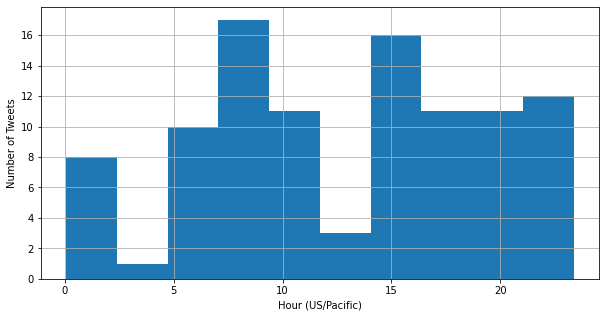

In [31]:
post_time_pst['hour'] = [post_time_pst.loc[i, 'time'].hour + post_time.loc[i, 'time'].minute/60 +
                     post_time_pst.loc[i, 'time'].second/3600 for i in range(len(post_time_pst))]
plt.figure(figsize=(10,5))
post_time_pst['hour'].hist()
plt.xlabel("Hour (US/Pacific)")
plt.ylabel("Number of Tweets");

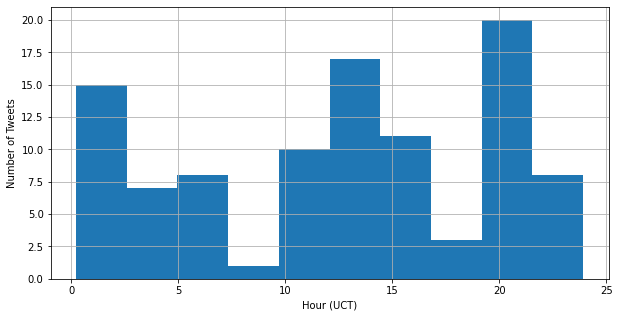

In [32]:
#Same code as above
post_time['hour'] = [post_time.loc[i, 'time'].hour + post_time.loc[i, 'time'].minute/60 +
                     post_time.loc[i, 'time'].second/3600 for i in range(len(post_time))]
plt.figure(figsize=(10,5))
post_time['hour'].hist()
plt.xlabel("Hour (UCT)")
plt.ylabel("Number of Tweets");

**Exercise 2:** Try scraping tweets from multiple locations and the same hashtag. Make a histogram for each location and see if there are any differences in the distribution of polarity of the tweets. Feel free to use multiple cells to avoid querying the API repeatedly.

In [57]:
# YOUR CODE HERE
# Within 2 km of UC, Berkeley
COVID_berk= download_recent_tweets_by_hashtag(hashtag = "COVID",
                                                       keys = keys,
                                                       location = "37.87442023168947, -122.25879564609362, 2km",
                                                       count = 200)


In [58]:
b_df = pd.DataFrame(COVID_berk)
b_df.head(5)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,Mon Apr 05 05:11:12 +0000 2021,1378938248244826112,1378938248244826112,RT @VegasVisions: Daughter of #COVID-19 victim pleads for stricter restrictions as cases surge in southern #Alberta | CBC News https://t.co…,False,"{'hashtags': [{'text': 'COVID', 'indices': [30, 36]}, {'text': 'Alberta', 'indices': [107, 115]}], 'symbols': [], 'user_mentions': [{'screen_name': 'VegasVisions', 'name': 'Vegas Visions ™', 'id': 1327442450957303809, 'id_str': '1327442450957303809', 'indices': [3, 16]}], 'ur...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,None,...,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Mon Apr 05 05:11:03 +0000 2021,1378938209384665091,1378938209384665091,"9 appointments at Walmart Supercenter (7800 N.w. Expressway, Oklahoma City)\n#Oklahoma #COVID #Vaccine… https://t.co/yzG7Q8JxQd",True,"{'hashtags': [{'text': 'Oklahoma', 'indices': [76, 85]}, {'text': 'COVID', 'indices': [86, 92]}, {'text': 'Vaccine', 'indices': [93, 101]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yzG7Q8JxQd', 'expanded_url': 'https://twitter.com/i/web/status/13789...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://www.bendytree.com"" rel=""nofollow"">Bendy Tree Social</a>",NaN,None,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
2,Mon Apr 05 05:11:02 +0000 2021,1378938206956134400,1378938206956134400,"RT @SENTHILSSK1982: ""Until one has loved an animal, a part of one's soul remains unawakened."" ― Anatole France\n\n#mondaythoughts #MondayMoti…",False,"{'hashtags': [{'text': 'mondaythoughts', 'indices': [112, 127]}], 'symbols': [], 'user_mentions': [{'screen_name': 'SENTHILSSK1982', 'name': 'Senthil kumar', 'id': 1070172748658356224, 'id_str': '1070172748658356224', 'indices': [3, 18]}], 'urls': []}","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Mon Apr 05 05:11:01 +0000 2021,1378938201327366144,1378938201327366144,"RT @rameshlaus: From 9,035 cases on Jan 25th to 103,558 on Apr 4th, the 2nd #CoronaWave in #India is spreading very fast..\n\nDuring the enti…",False,"{'hashtags': [{'text': 'CoronaWave', 'indices': [76, 87]}, {'text': 'India', 'indices': [91, 97]}], 'symbols': [], 'user_mentions': [{'screen_name': 'rameshlaus', 'name': 'Ramesh Bala', 'id': 102268884, 'id_str': '102268884', 'indices': [3, 14]}], 'urls': []}","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,None,...,52,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Mon Apr 05 05:10:59 +0000 2021,1378938194050355210,1378938194050355210,RT @PaddyTheBaddy: Up there with the funniest thing what happened all week at the trilogy @chrisert88 🤣🤣🤣🤣🤣🤣 #covidtest #covid #funny #come…,False,"{'hashtags': [{'text': 'covidtest', 'indices': [109, 119]}, {'text': 'covid', 'indices': [120, 126]}, {'text': 'funny', 'indices': [127, 133]}], 'symbols': [], 'user_mentions': [{'screen_name': 'PaddyTheBaddy', 'name': 'Paddy Pimblett', 'id': 99596334, 'id_str': '99596334', '...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,None,...,17,0,False,False,en,NaN,NaN,NaN,NaN,NaN


In [55]:
COVID_mex= download_recent_tweets_by_hashtag(hashtag = "COVID",
                                                       keys = keys,
                                                       location = "19.4198237334946, -99.14568428397733, 2km",
                                                       count = 200)

In [56]:
m_df = pd.DataFrame(COVID_mex)
m_df.head(5)

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status
0,Mon Apr 05 05:10:34 +0000 2021,1378938089154834432,1378938089154834432,RT @thewalleyapp: When you are on a monthly budget but an unplanned expense comes\n#covid #lockdown2021 https://t.co/UxZ5CMOYup,False,"{'hashtags': [{'text': 'covid', 'indices': [82, 88]}, {'text': 'lockdown2021', 'indices': [89, 102]}], 'symbols': [], 'user_mentions': [{'screen_name': 'thewalleyapp', 'name': 'Walley', 'id': 1368462812918423558, 'id_str': '1368462812918423558', 'indices': [3, 16]}], 'urls': ...","{'media': [{'id': 1378049034561064962, 'id_str': '1378049034561064962', 'indices': [103, 126], 'media_url': 'http://pbs.twimg.com/media/Ex_QS7QVEAIK89A.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Ex_QS7QVEAIK89A.jpg', 'url': 'https://t.co/UxZ5CMOYup', 'display_url':...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,...,False,19,0,False,False,False,en,NaN,NaN,NaN
1,Mon Apr 05 05:09:57 +0000 2021,1378937933349019650,1378937933349019650,RT @RavMABAY: My Jewish parents got to hug their Jewish grandchildren for the first time in a year because some brilliant Muslim scientists…,False,"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'RavMABAY', 'name': 'Rabbi Michael Adam Latz #BlackLivesMatter', 'id': 63227112, 'id_str': '63227112', 'indices': [3, 12]}], 'urls': []}",NaN,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,...,False,575,0,False,False,NaN,en,NaN,NaN,NaN
2,Mon Apr 05 05:09:57 +0000 2021,1378937932845785090,1378937932845785090,"RT @Teensthack: Highest single day rise of #Covid cases in India. 103,558 cases in last 24 hours.",False,"{'hashtags': [{'text': 'Covid', 'indices': [43, 49]}], 'symbols': [], 'user_mentions': [{'screen_name': 'Teensthack', 'name': 'Teena Thacker', 'id': 2215812403, 'id_str': '2215812403', 'indices': [3, 14]}], 'urls': []}",NaN,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,...,False,54,0,False,False,NaN,en,NaN,NaN,NaN
3,Mon Apr 05 05:09:53 +0000 2021,1378937915531612160,1378937915531612160,"Up, close &amp; personal: 2 families in near relations, handling #COVID19 trauma.\nEach home has a casual 30 + yr old ge… https://t.co/deL335mozg",True,"{'hashtags': [{'text': 'COVID19', 'indices': [65, 73]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/deL335mozg', 'expanded_url': 'https://twitter.com/i/web/status/1378937915531612160', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [121, 144]}]}",NaN,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,...,False,0,0,False,False,NaN,en,NaN,NaN,NaN
4,Mon Apr 05 05:09:40 +0000 2021,1378937864524734464,1378937864524734464,"RT @rameshlaus: From 9,035 cases on Jan 25th to 103,558 on Apr 4th, the 2nd #CoronaWave in #India is spreading very fast..\n\nDuring the enti…",False,"{'hashtags': [{'text': 'CoronaWave', 'indices': [76, 87]}, {'text': 'India', 'indices': [91, 97]}], 'symbols': [], 'user_mentions': [{'screen_name': 'rameshlaus', 'name': 'Ramesh Bala', 'id': 102268884, 'id_str': '102268884', 'indices': [3, 14]}], 'urls': []}",NaN,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,...,False,51,0,False,False,NaN,en,NaN,NaN,NaN


In [37]:
post_time_berk = pd.DataFrame(COVID_berk)[['id', 'created_at']]
post_time_berk['time'] = pd.to_datetime(post_time_berk['created_at'])
post_time_berk['time'].head()

0   2021-04-05 05:05:32+00:00
1   2021-04-05 05:05:31+00:00
2   2021-04-05 05:05:30+00:00
3   2021-04-05 05:05:29+00:00
4   2021-04-05 05:05:23+00:00
Name: time, dtype: datetime64[ns, UTC]

(0.0, 30.0)

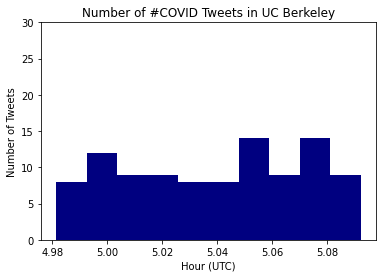

In [63]:
post_time_berk['hour'] = [post_time_berk.loc[i, 'time'].hour + post_time_berk.loc[i, 'time'].minute/60 +
                     post_time_berk.loc[i, 'time'].second/3600 for i in range(len(post_time_berk))]
post_time_berk['hour'].hist(color='navy')
plt.title('Number of #COVID Tweets in UC Berkeley')
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of Tweets")
plt.grid(False)
plt.ylim(0,30)

In [60]:
post_time_mex = pd.DataFrame(COVID_mex)[['id', 'created_at']]
post_time_mex['time'] = pd.to_datetime(post_time_mex['created_at'])
post_time_mex['time'].head()

0   2021-04-05 05:10:34+00:00
1   2021-04-05 05:09:57+00:00
2   2021-04-05 05:09:57+00:00
3   2021-04-05 05:09:53+00:00
4   2021-04-05 05:09:40+00:00
Name: time, dtype: datetime64[ns, UTC]

(0.0, 30.0)

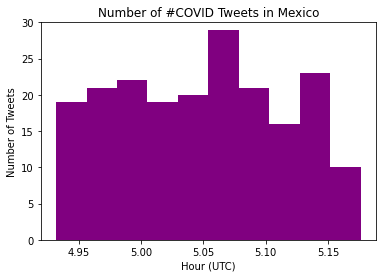

In [62]:
post_time_mex['hour'] = [post_time_mex.loc[i, 'time'].hour + post_time_mex.loc[i, 'time'].minute/60 +
                     post_time_mex.loc[i, 'time'].second/3600 for i in range(len(post_time_mex))]
post_time_mex['hour'].hist(color='purple')

plt.title('Number of #COVID Tweets in Mexico')

plt.xlabel("Hour (UTC)")
plt.ylabel("Number of Tweets")
plt.grid(False)
plt.ylim(0,30)